# Problem Statement
```
To identify the best question authors on the platform. This identification will bring more insight into increasing the user engagement. Given the tag of the question, number of views received, number of answers, username and reputation of the question author, the problem requires you to predict the upvote count that the question will receive.
```

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.preprocessing import Binarizer, LabelEncoder, StandardScaler
from catboost import CatBoostRegressor

from math import *
%matplotlib inline

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [3]:
train_df.head()

,ID,Tag,Reputation,Answers,Username,Views,Upvotes
0,52664,a,3942.0,2.0,155623,7855.0,42.0
1,327662,a,26046.0,12.0,21781,55801.0,1175.0
2,468453,c,1358.0,4.0,56177,8067.0,60.0
3,96996,a,264.0,3.0,168793,27064.0,9.0
4,131465,c,4271.0,4.0,112223,13986.0,83.0


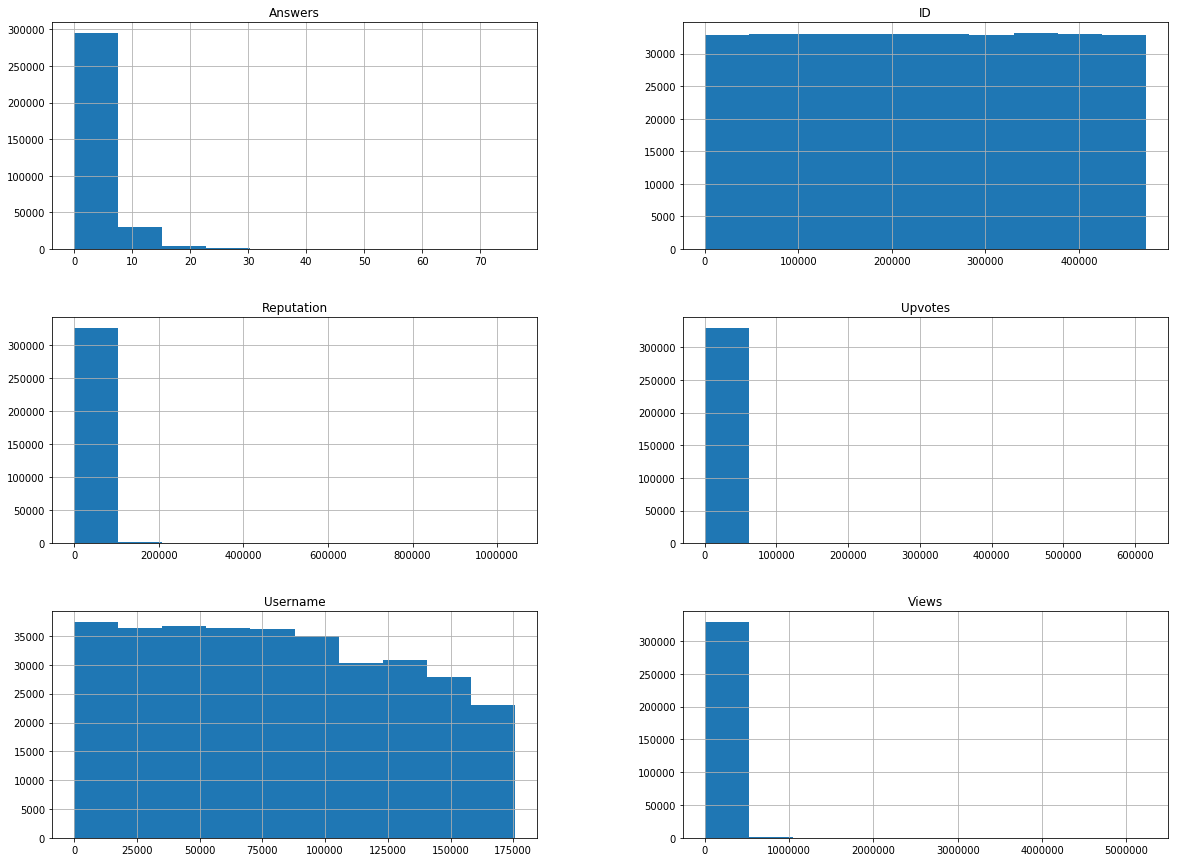

In [4]:
train_df.hist(figsize=(20,15))
plt.show()

In [5]:
train_df.describe()

,ID,Reputation,Answers,Username,Views,Upvotes
count,330045.000000,3.300450e+05,330045.000000,330045.000000,3.300450e+05,330045.000000
mean,235748.682789,7.773147e+03,3.917672,81442.888803,2.964507e+04,337.505358
std,136039.418471,2.706141e+04,3.579515,49215.100730,8.095646e+04,3592.441135
min,1.000000,0.000000e+00,0.000000,0.000000,9.000000e+00,0.000000
25%,117909.000000,2.820000e+02,2.000000,39808.000000,2.594000e+03,8.000000
50%,235699.000000,1.236000e+03,3.000000,79010.000000,8.954000e+03,28.000000
75%,353620.000000,5.118000e+03,5.000000,122559.000000,2.687000e+04,107.000000
max,471493.000000,1.042428e+06,76.000000,175738.000000,5.231058e+06,615278.000000


In [6]:
train_df.isnull().sum()

ID            0
Tag           0
Reputation    0
Answers       0
Username      0
Views         0
Upvotes       0
dtype: int64

In [7]:
train_df.drop(['ID', 'Username'], axis=1, inplace=True)
test_df.drop(['ID', 'Username'], axis=1, inplace=True)

In [8]:
train_df['Reputation'].describe()

count    3.300450e+05
mean     7.773147e+03
std      2.706141e+04
min      0.000000e+00
25%      2.820000e+02
50%      1.236000e+03
75%      5.118000e+03
max      1.042428e+06
Name: Reputation, dtype: float64

In [9]:
mean = train_df.groupby('Tag').mean()
mean

,Reputation,Answers,Views,Upvotes
Tag,,,,
a,6065.168102,4.259189,31800.916327,316.460136
c,10566.420657,4.047697,26746.676875,327.569916
h,6985.072116,3.778837,33948.958812,384.719704
i,5238.884290,3.679753,15806.680093,117.386636
j,8285.527730,4.347256,43291.211236,540.364686
o,5656.755603,3.380654,13504.645538,112.157294
p,8062.053033,3.977077,33184.984334,407.351971
r,5290.282109,2.304292,12033.055940,79.027246
s,6545.661622,3.600866,25807.082965,237.031385


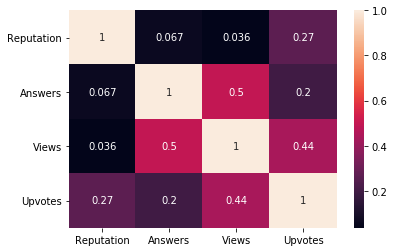

In [10]:
corr = train_df.corr()
sns.heatmap(corr, annot=True)
plt.show()

Text(0, 0.5, 'Answers')

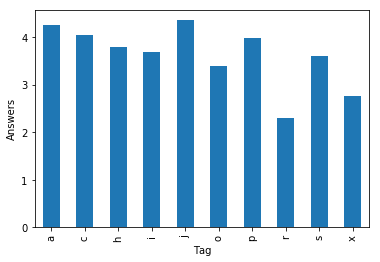

In [11]:
mean['Answers'].plot(kind='bar')
plt.ylabel('Answers')

Text(0, 0.5, 'Views')

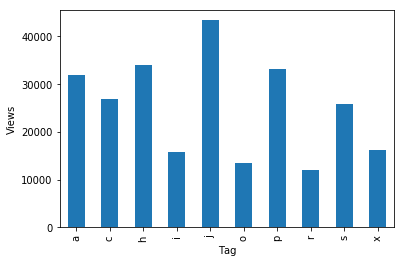

In [12]:
mean['Views'].plot(kind='bar')
plt.ylabel('Views')

In [13]:
bn = Binarizer(threshold=4)
train_df['watched'] = bn.fit_transform([train_df['Answers']])[0]
# train_df['watched'] = np.where(train_df['Answers']>4, 1, 0)

test_df['watched'] = bn.fit_transform([test_df['Answers']])[0]



In [14]:
# train_df = pd.get_dummies(train_df, columns=['Tag'], drop_first=True)
# test_df = pd.get_dummies(test_df, columns=['Tag'], drop_first=True)

In [15]:
le = LabelEncoder()
train_df['Tag'] = le.fit_transform(train_df['Tag'])
test_df['Tag'] = le.fit_transform(test_df['Tag'])
train_df.head()

,Tag,Reputation,Answers,Views,Upvotes,watched
0,0,3942.0,2.0,7855.0,42.0,0.0
1,0,26046.0,12.0,55801.0,1175.0,1.0
2,1,1358.0,4.0,8067.0,60.0,0.0
3,0,264.0,3.0,27064.0,9.0,0.0
4,1,4271.0,4.0,13986.0,83.0,0.0


## Splitting the dataset

In [16]:
X = train_df.drop('Upvotes', axis=1)
y = train_df['Upvotes']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
st = StandardScaler()
X_train = st.fit_transform(X_train)
X_test = st.transform(X_test)

In [63]:
model = RandomForestRegressor(random_state=42, criterion= 'mse').fit(X_train, y_train)
ytr_pred = model.predict(X_train)
y_pred = model.predict(X_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [64]:
print(sqrt(mean_squared_error(y_train, ytr_pred)))
sqrt(mean_squared_error(y_test, y_pred))

747.1602468201984


1495.4135761489447

In [65]:
print(model.score(X_train, y_train))
model.score(X_test, y_test)

0.9545944575831743


0.8543044510210087

In [21]:
# Decision Tree

# le                       # without st             # without feat, st        # with st without feat
# 1534.888351053825        # 1527.6834620899995     # 1806.6133479163989      # 1813.0498076573301
# 0.8465110107681428       # 0.8479486079718385     # 0.7873555386592369      # 0.785837653690262

# get dummies              # without st             # without feat, st        # with st without feat
# 1555.990148203301        # 1557.5809056750445     # 1564.7710191712245      # 1564.6149842284278
# 0.842261636111395        # 0.8419389454487246     # 0.8404762926608149      # 0.8405081056624587

In [22]:
model.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=42, splitter='best')

In [23]:
sub = pd.read_csv('ss.csv')
sub['Upvotes'] = model.predict(test_df)
sub.to_csv('ss.csv', index=False)

In [68]:
# params = {'n_estimators': [200,300],
#                'max_features': ['auto', 'sqrt'],
#                'max_depth': [7, 10, 15, None],
#                'min_samples_split': [2, 5, 10],
#                'min_samples_leaf': [1, 2, 4],
#                'bootstrap': [True, False]}
# rf_random = RandomizedSearchCV(estimator = model, param_distributions = params, n_iter = 100, cv = 3, verbose=2, 
#                                random_state=42)

params =  {
    'n_estimators': [300],
 'min_samples_split': [2],
 'min_samples_leaf': [1],
 'max_features': ['auto'],
 'max_depth': [10],
 'bootstrap': [True],
}

In [69]:
2*2*4*3*3*2

288

In [70]:
rf_random = RandomizedSearchCV(estimator = model, param_distributions = params, n_iter = 100, cv = 3, verbose=2, 
                               random_state=42)

In [ ]:
rf_random.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:266: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] n_estimators=300, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=10, bootstrap=True 
[CV]  n_estimators=300, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=10, bootstrap=True, total= 5.7min
[CV] n_estimators=300, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=10, bootstrap=True 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.7min remaining:    0.0s


[CV]  n_estimators=300, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=10, bootstrap=True, total= 3.5min
[CV] n_estimators=300, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=10, bootstrap=True 


In [26]:
rf_random.best_params_

{'n_estimators': 300,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 10,
 'bootstrap': True}

In [28]:
y_pred = rf_random.predict(X_test)

In [29]:
rf_random.score(X_train, y_train)

0.9732175485242187

In [30]:
rf_random.score(X_test, y_test)

0.8583320651390942

In [53]:
sqrt(mean_squared_error(y_test, y_pred))

1474.5990797104205

In [34]:
model = RandomForestRegressor(n_estimators= 300,
                              min_samples_split= 2,
                              min_samples_leaf= 1,
                              max_features= 'auto',
                              max_depth= 10,
                              bootstrap= True)

In [35]:
model.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=300,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [36]:
T_pred = model.predict(test_df)

In [52]:
sub = pd.read_csv('ss.csv')
sub['Upvotes'] = T_pred
sub.to_csv('ss.csv', index=False)